In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import metrics

## Loading the Dataset

In [3]:
# Load the cleaned 2019 dataset for model building

taxi_2019_df = pd.read_pickle("../data/2019_df.pkl")

In [4]:
# Load the cleaned 2020 dataset for prediction

taxi_2020_df = pd.read_pickle("../data/2020_df.pkl")

In [5]:
# Append new area feature according to trips Pickup Location ID
zone = pd.read_csv("../data/loc_id_category.csv")
zone = zone[["LocationID", "area"]]

taxi_2019_merge = pd.merge(taxi_2019_df, zone, left_on='PULocationID', right_on='LocationID')
taxi_2020_merge = pd.merge(taxi_2020_df, zone, left_on='PULocationID', right_on='LocationID')

In [6]:
taxi_2019_merge.head(1)

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tolls_amount,diff_hour,tip_pct,pickup_month,pickup_day_of_week,pickup_hour,dropoff_month,dropoff_day_of_week,dropoff_hour,LocationID,area
0,1,1.5,1,151,239,7.0,0.0,0.111111,16.582915,1,3,0,1,3,0,151,Manhattan


## Splitting Dataset into Training and Test Sets

In [7]:
X = taxi_2019_merge[["trip_distance", "pickup_hour", "diff_hour", "area"]]
y = taxi_2019_merge["tip_pct"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

## Bivariate Visualisation

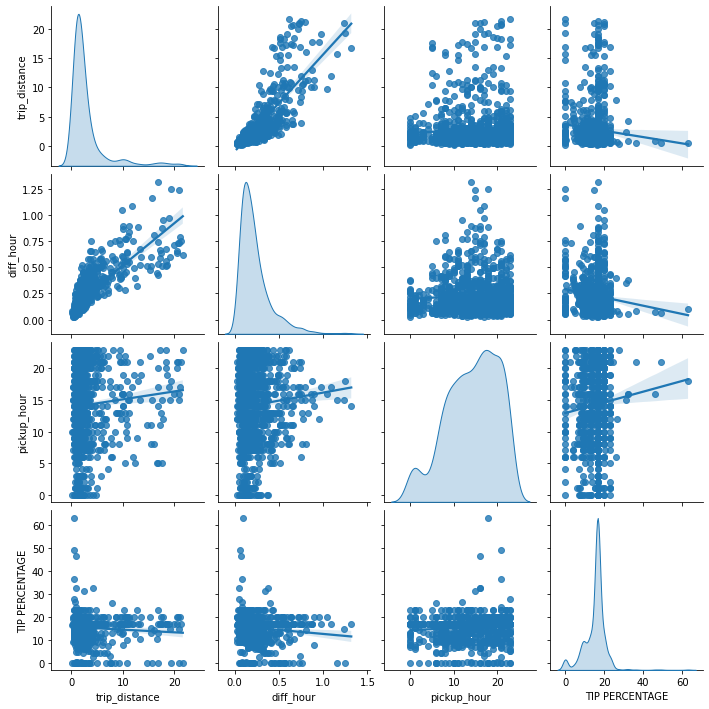

In [8]:
# Visualise the countinuous variables and tip percentage

train_dataset = X_train[["trip_distance", "pickup_hour", "diff_hour"]].copy()
train_dataset.insert(0, "TIP PERCENTAGE", y_train) # the target variable
train_sample = train_dataset.sample(1000, random_state=1) # randomly select 1000 instances

ax = sns.pairplot(train_sample[["trip_distance", "diff_hour", "pickup_hour", 
                                "TIP PERCENTAGE"]], kind='reg', diag_kind='kde')

## Transforming the Variables

In [9]:
# Encoding the categorical variable 'area'
# Scaling the numerical variables

t = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['area']),
    ('scale', StandardScaler(), ["trip_distance", "pickup_hour", "diff_hour"])
], remainder='passthrough') # the default is to drop untransformed columns

transformer = t.fit(X_train)

In [10]:
X_train_tf = transformer.transform(X_train)
X_test_tf = transformer.transform(X_test)

In [11]:
## For 2020 data
X_2020 = taxi_2020_merge[["trip_distance", "pickup_hour", "diff_hour", "area"]]
y_2020 = taxi_2020_merge["tip_pct"]

X_2020_tf = transformer.transform(X_2020)

## Feature selection

## Modelling

### Baseline Regression Model

In [12]:
# Create a dummy regressor
dummy_mean = DummyRegressor(strategy='mean')

# "Train" dummy regressor
dummy_mean.fit(X_train_tf, y_train)

# Get R-squared score
# The result is approximately zero
dummy_mean.score(X_test_tf, y_test) 

-2.2918966724461143e-08

In [13]:
y_pred_dummy = dummy_mean.predict(X_test_tf)
print('MSE:',metrics.mean_squared_error(y_test, y_pred_dummy))

MSE: 27.249612734758248


In [14]:
# For 2020
pred_2020_dummy = dummy_mean.predict(X_2020_tf)
print('MSE:',metrics.mean_squared_error(y_2020, pred_2020_dummy))

MSE: 23.595284643568164


In [15]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train_tf,y_train)
y_pred = lm.predict(X_test_tf)
print("R Squared value for linear regression model :",lm.score(X_train_tf,y_train))
print("Estimated intercept Coefficients :", lm.intercept_)
print("Estimated Co-efficients :",lm.coef_)
print("Estimated Number of Co-efficients :",len(lm.coef_))
print('R^2=',metrics.explained_variance_score(y_test,y_pred))
print('MSE:',metrics.mean_squared_error(y_test,y_pred))

R Squared value for linear regression model : 0.048885648877857735
Estimated intercept Coefficients : 88650790520.23788
Estimated Co-efficients : [-8.86507905e+10 -8.86507905e+10 -8.86507905e+10 -5.05569458e-01
  8.59136581e-02 -4.02023315e-01]
Estimated Number of Co-efficients : 6
R^2= 0.04935668420498052
MSE: 25.904661730065765


In [16]:
# Score for 2020 dataset prediction


print('R^2=',metrics.explained_variance_score(y_2020, lm.predict(X_2020_tf)))
print('MSE:',metrics.mean_squared_error(y_2020,lm.predict(X_2020_tf)))

R^2= -0.01569461458693966
MSE: 23.96405972739616


### XG Boost Model

In [17]:
import xgboost as xg

In [18]:
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 132)
  
# Fitting the model
xgb_r.fit(X_train_tf, y_train)
  
# Predict the model
y_pred_xgb = xgb_r.predict(X_test_tf)

[09:28:48] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [19]:
print('R^2=',metrics.explained_variance_score(y_test,y_pred_xgb))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_xgb))

R^2= 0.06448941218109572
MSE: 25.6626454420968


In [20]:
# For 2020 dataset prediction
print('R^2=',metrics.explained_variance_score(y_2020,xgb_r.predict(X_2020_tf)))
print('MSE:',metrics.mean_squared_error(y_2020,xgb_r.predict(X_2020_tf)))

R^2= -0.007460921404148779
MSE: 23.91294477537072
